# **Trabajo 2: Aprendizaje de Modelos de Decisión**

### Tadeo Cabrera Gómez

## **Índice** 📚

### **1. [Introducción](#1-introduccion)**
 - **1.1 Dataset seleccionado**

### **2. [Preprocesado de datos](#2-preprocesado-de-datos)**

 - **2.1. Análisis del conjunto de datos**
    - 2.1.1. Estudio de valores ausentes
    - 2.1.2. Estudio de parámetros estadísticos
    - 2.1.3. Análisis del tipo de características
    - 2.1.4. Estudio de los valores de clasificación
 - **2.2. Tratamiento de valores ausentes**
    - 2.2.1. Imputación de datos
    - 2.2.2. Eliminación de datos con valores ausentes
    - 2.2.3. Eliminación de características
 - **2.3. Modificación de características**
    - 2.3.1. Label Encoding
    - 2.3.2. One Hot Encoding
    - 2.3.3. Discretizado
    - 2.3.4. Normalización
    - 2.3.5. Estandarización
 - **2.4. Reducción del número de características**
    - 2.4.1. Reducción de características basada en modelos
    - 2.4.2. Reducción recursiva de características
    - 2.4.3. Análisis de componentes principales
 - **2.5. Modificación del conjunto de ejemplos**
    - 2.5.1. Eliminación de muestras
    - 2.5.2. Over-sampling
    - 2.5.3. Under-sampling
 - **2.6. Selección de distintas versiones del trabajo de datos**
    - 2.6.1. Dataset 1
    - 2.6.2. Dataset 2
    - 2.6.3. Dataset 3
    - 2.6.4. Dataset 4

### **3. [Aprendizaje de modelos de decisión](#3-aprendizaje-de-modelos-de-decision)**
 - **3.1. Aprendizaje basado en instancias**
 - **3.2. Árboles de decisión**
 - **3.3. Ensemble learning con árboles**
 - **3.4. Modelos lineales**
 - **3.5. Redes neuronales**

### **4. [Validación, ajuste y evaluación](#3-aprendizaje-de-modelos-de-decision)**
 - **4.1. Construcción equilibrada de modelos**
   - 4.1.1. Gridsearch
   - 4.1.2. Validación cruzada
 - **4.2. Evaluación del rendimiento**
   - 4.2.1. Matriz de confusión
   - 4.2.2. Informe de clasificación
 - **4.3. Curvas de rendimiento**
   - 4.3.1. Curva PR
   - 4.3.2. Curva ROC

### **5. [Conclusiones](#5-conclusion)**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_curve, average_precision_score, roc_curve, roc_auc_score, auc
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree

import tensorflow as tf
from tensorflow import keras

from copy import deepcopy

import warnings
warnings.filterwarnings('ignore')

# **1. Introducción**

En este trabajo vamos a aplicar los conceptos estudiados durante el curso para analizar un conjunto de datos y realizar un aprendizaje de modelos de decisión para el dominio que describen los datos en una tarea de clasificación. He intentado que el trabajo esté lo más ordenado posible para facilitar la corrección.

### **1.1. Dataset seleccionado**

El dataset que he seleccionado es **Chronic Kidney Disease**, ya que es el que veo que tiene mayor variedad de datos, lo que me permitirá poder realizar todos los apartados del preprocesado de datos sin tener que alterarlos a mano.

He tenido problemas usando `arff` para leer el fichero, por lo que he tenido que implementar una función que lea el fichero a mano. Además, el fichero de datos tenía una serie de problemas que he tenido que tratar en la función:

 - A pesar de ser un dataset con 25 columnas, algunas filas tienen 26 columnas, en todos los casos estando la última columna vacía.
 - Algunas filas tienen tabulaciones en algunos datos.
 - Una de las filas tiene un valor de clasificación *"no"*. Como el dataset indica que esa columna solo puede tener los valores *ckd* o *notckd* simplemente la he tratado como *notckd*.
 - De la misma forma, una fila toma el valor *"no"* en la columna *appet*, que solo puede tomar los valores *good* o *poor*. La he tratado como *poor*. También ocurre en ñas columnas *dm* y *pe*.

In [3]:
# Escribir aqui la ruta del archivo chronic_kidney_disease.arff
ruta_fichero = 'Datasets/Chronic_Kidney_Disease/chronic_kidney_disease.arff'

In [4]:
def cargar_arff(ruta_archivo):

    with open(ruta_archivo, 'r') as file:
        lines = file.readlines()
    
    # Extraemos los atributos
    atributos = []
    data_start = False
    for line in lines:
        line = line.strip()
        if line.lower().startswith('@attribute'):
            atributo = line.split()[1].strip("'")
            atributos.append(atributo)
        elif line.lower().startswith('@data'):
            # Ya no quedan mas atributos y a partir de aqui son los datos
            data_start = True
            break

    # Extraemos los datos
    datos = []
    if data_start:
        data_index = lines.index('@data\n') + 1
        for line in lines[data_index:]:
            line = line.strip().replace('\t', '')  # Eliminar tabulaciones
            if line and not line.startswith('%'):
                fila = [None if (val == '?') else val for val in line.split(',')]
                if len(fila) > len(atributos):
                    fila = fila[:len(atributos)]
                datos.append(fila)

    # Convertir a DataFrame
    df = pd.DataFrame(datos, columns=atributos)

    # Convertir valores numericos a su tipo correcto sin afectar texto
    for col in df.columns:
        try:
            # Intentar convertir primero a integer
            df[col] = pd.to_numeric(df[col], errors='ignore')
            if pd.api.types.is_float_dtype(df[col]):
                if df[col].dropna().apply(float.is_integer).all():
                    df[col] = df[col].astype('Int64')  # Convertir a entero preservando valores nulos
        except Exception as e:
            pass # Si no se puede convertir, continuar dejando la columna como esta

    # Corregimos las columnas con valores erroneos
    df['class'] = df['class'].replace('no', 'notckd')
    df['appet'] = df['appet'].replace('no', 'poor')
    df['dm'] = df['dm'].replace(' yes','yes').replace('',None)
    df['pe'] = df['pe'].replace('good','yes')
        
    return df


In [5]:
DATASET_ORIGINAL = cargar_arff(ruta_fichero)

DATASET_ORIGINAL_X = DATASET_ORIGINAL.drop(columns=['class'])
DATASET_ORIGINAL_Y = DATASET_ORIGINAL['class']

DATASET_ORIGINAL.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48,80,1.020,1,0,None,normal,notpresent,notpresent,121,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7,50,1.020,4,0,None,normal,notpresent,notpresent,<NA>,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,...,35,7300,4.6,no,no,no,good,no,no,ckd


# **2. Preprocesado de datos**

Para el preprocesado de datos voy a empezar realizando un análisis del conjunto de datos, luego voy a crear funciones para todas las técnicas de procesado de datos que pide el ejercicio, y por último, una vez estén los datos analizados y las funciones creadas, escoger las distintas versiones de los datos preprocesados.

### **2.1. Análisis del conjunto de datos**

#### 2.1.1. Estudio de valores ausentes

In [7]:
DATASET_ORIGINAL.isnull().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         3
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

#### 2.1.2. Estudio de parámetros estadísticos

En el análisis de parámetros estadísticos en un conjunto de datos, calculamos distintas medidas estadísticas para comprender las características de los datos. Para ello vamos a crear una función que nos proporcione la siguiente información, la cual nos podrá servir en el futuro:
- **Para columnas numéricas**: Media, mediana, varianza (dispersión de los valores respecto a la media), y valores máximos y mínimos
- **Para columnas categóricas**: Frecuencia de cada categoría y moda (categoría más frecuente)

In [9]:
def statistical_parameters(dataset):
    resultado = {}
    
    for columna in dataset.columns:
        if pd.api.types.is_numeric_dtype(dataset[columna]):
            resultado[columna] = {
                ' - tipo': 'Numérica',
                ' - media': dataset[columna].mean(),
                ' - mediana': dataset[columna].median(),
                ' - varianza': dataset[columna].var(),
                ' - máximo': dataset[columna].max(),
                ' - mínimo': dataset[columna].min()
            }
        elif pd.api.types.is_categorical_dtype(dataset[columna]) or dataset[columna].dtype == 'object':
            frecuencias = dataset[columna].value_counts()
            resultado[columna] = {
                ' - tipo': 'Categórica',
                ' - frecuencias': frecuencias.to_dict(),
                ' - moda': frecuencias.idxmax() if not frecuencias.empty else None
            }
        else:
            resultado[columna] = {
                ' - tipo': '?????'
            }
    
    return resultado

In [10]:
results = statistical_parameters(DATASET_ORIGINAL)

for columna, estadisticas in results.items():
    print(f"\nColumna: {columna}")
    for clave, valor in estadisticas.items():
        print(f"  {clave}: {valor}")


Columna: age
   - tipo: Numérica
   - media: 51.48337595907928
   - mediana: 55.0
   - varianza: 294.7990819070103
   - máximo: 90
   - mínimo: 2

Columna: bp
   - tipo: Numérica
   - media: 76.46907216494846
   - mediana: 80.0
   - varianza: 187.24193505421027
   - máximo: 180
   - mínimo: 50

Columna: sg
   - tipo: Numérica
   - media: 1.0174079320113314
   - mediana: 1.02
   - varianza: 3.267970963172795e-05
   - máximo: 1.025
   - mínimo: 1.005

Columna: al
   - tipo: Numérica
   - media: 1.0169491525423728
   - mediana: 0.0
   - varianza: 1.8297402410332744
   - máximo: 5
   - mínimo: 0

Columna: su
   - tipo: Numérica
   - media: 0.45014245014245013
   - mediana: 0.0
   - varianza: 1.2082214082214084
   - máximo: 5
   - mínimo: 0

Columna: rbc
   - tipo: Categórica
   - frecuencias: {'normal': 201, 'abnormal': 47}
   - moda: normal

Columna: pc
   - tipo: Categórica
   - frecuencias: {'normal': 259, 'abnormal': 76}
   - moda: normal

Columna: pcc
   - tipo: Categórica
   - frecu

#### 2.1.3. Análisis del tipo de características

En el propio fichero `chronic_kidney_disease.arff`, antes de mostrar los datos, se nos indica el formato de cada columna y los posibles valores que puede tomar. Usando estos datos he creado la siguiente lista:

 - **age:** Numérico discreto.
 - **bp:** Numérico discreto.
 - **sg:** Numérico continuo. (Posibles valores: 1.005, 1.010, 1.015, 1.020, 1.025)
 - **al:** Numérico discreto. (Posibles valores: 0, 1, 2, 3, 4, 5)
 - **su:** Numérico discreto. (Posibles valores: 0, 1, 2, 3, 4, 5)
 - **rbc:** Categórico. (Posibles valores: normal, abnormal)
 - **pc:** Categórico. (Posibles valores: normal, abnormal)
 - **pcc:** Categórico. (Posibles valores: present, notpresent)
 - **ba:** Categórico. (Posibles valores: present, notpresent)
 - **bgr:** Numérico discreto.
 - **bu:** Numérico continuo.
 - **sc:** Numérico continuo.
 - **sod:** Numérico continuo.
 - **pot:** Numérico continuo.
 - **hemo:** Numérico continuo.
 - **pcv:** Numérico discreto.
 - **wbcc:** Numérico discreto.
 - **rbcc:** Numérico continuo.
 - **htn:** Categórico. (Posibles valores: yes, no)
 - **dm:** Categórico. (Posibles valores: yes, no)
 - **cad:** Categórico. (Posibles valores: yes, no)
 - **appet:** Categórico. (Posibles valores: good, poor)
 - **pe:** Categórico. (Posibles valores: yes, no)
 - **ane:** Categórico. (Posibles valores: yes, no)


Alternativamente, se puede simplemente usar la siguiente función:

In [12]:
DATASET_ORIGINAL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     391 non-null    Int64  
 1   bp      388 non-null    Int64  
 2   sg      353 non-null    float64
 3   al      354 non-null    Int64  
 4   su      351 non-null    Int64  
 5   rbc     248 non-null    object 
 6   pc      335 non-null    object 
 7   pcc     396 non-null    object 
 8   ba      396 non-null    object 
 9   bgr     356 non-null    Int64  
 10  bu      381 non-null    float64
 11  sc      383 non-null    float64
 12  sod     313 non-null    float64
 13  pot     312 non-null    float64
 14  hemo    348 non-null    float64
 15  pcv     329 non-null    Int64  
 16  wbcc    294 non-null    Int64  
 17  rbcc    269 non-null    float64
 18  htn     398 non-null    object 
 19  dm      397 non-null    object 
 20  cad     398 non-null    object 
 21  appet   399 non-null    object 
 22  pe

#### 2.1.4. Estudio de los valores de clasificación

En este dataset, el valor de clasificación es la última columna, **class**, con los valores categóricos ckd y notckd. Vamos también a comprobar la cantidad de datos que hay que para posible valor, ya que esa información nos servirá más adelante, cuando queramos evaluar el modelo.

In [14]:
DATASET_ORIGINAL["class"].value_counts()

class
ckd       250
notckd    150
Name: count, dtype: int64

### **2.2. Tratamiento de valores ausentes**

Es bastante común que algunos valores del dataset sean nulos. Para entrenar los modelos, es necesario deshacernos de dichos valores nulos. Sin embargo, esto se puede hacer de varias formas, las cuales veremos a continuación:

#### 2.2.1. Imputación de datos

La primera solución para tratar los valores nulos es rellenarlos con otros valores. Esto se puede hacer de distintas formas, pero lo más eficiente suele ser sustituirlo por la moda, la media o la mediana de los valores no nulos de la columna, dependiendo de si esta es numérica o categórica.

In [16]:
# Para valores numericos
def impute_numeric_data(data, column, uses_mean=True):
    if not pd.api.types.is_numeric_dtype(data[column]):
        raise ValueError(f"La columna '{column}' no es numérica.")
    if uses_mean:
        fill_value = data[column].mean()
    else:
        fill_value = data[column].median()
        
    if pd.api.types.is_integer_dtype(data[column]): # Si la columna es integer convertimos el valor
        fill_value = round(fill_value) 
        
    data[column] = data[column].fillna(fill_value)
    return data

# Para valores categoricos
def impute_categoric_data(data, column):
    if not pd.api.types.is_categorical_dtype(data[column]) and not pd.api.types.is_object_dtype(data[column]):
        raise ValueError(f"La columna '{column}' no es categórica.")
    
    fill_value = data[column].mode()[0]
    data[column] = data[column].fillna(fill_value)
    return data

In [17]:
# Usando la media
filtered_dataset = DATASET_ORIGINAL[["bgr","bu","sc"]]
print(f"Valores nulos de la columna bgr: {filtered_dataset['bgr'].isnull().sum()}")
print("Media de la columna bgr",filtered_dataset['bgr'].mean())
filtered_dataset = impute_numeric_data(filtered_dataset, "bgr",True)
print(filtered_dataset.head())
print("Valores nulos de la columna bgr tras eliminar nulos:",filtered_dataset['bgr'].isnull().sum())

Valores nulos de la columna bgr: 44
Media de la columna bgr 148.0365168539326
   bgr    bu   sc
0  121  36.0  1.2
1  148  18.0  0.8
2  423  53.0  1.8
3  117  56.0  3.8
4  106  26.0  1.4
Valores nulos de la columna bgr tras eliminar nulos: 0


In [18]:
# Usando la mediana
filtered_dataset = DATASET_ORIGINAL[["age","bu","sc"]]
print(f"Valores nulos de la columna age: {filtered_dataset['age'].isnull().sum()}")
print("Mediana de la columna age",filtered_dataset['age'].median())
filtered_dataset = impute_numeric_data(filtered_dataset, "age",False)
print(filtered_dataset.head())
print("Valores nulos de la columna age tras eliminar nulos:",filtered_dataset['age'].isnull().sum())

Valores nulos de la columna age: 9
Mediana de la columna age 55.0
   age    bu   sc
0   48  36.0  1.2
1    7  18.0  0.8
2   62  53.0  1.8
3   48  56.0  3.8
4   51  26.0  1.4
Valores nulos de la columna age tras eliminar nulos: 0


In [19]:
# Usando la moda
filtered_dataset = DATASET_ORIGINAL[["rbc","bu","sc"]] # Appet es una variable categorica que toma los valores good o poor
print(f"Valores nulos de la columna rbc: {filtered_dataset['rbc'].isnull().sum()}")
print("Moda de la columna rbc:",filtered_dataset['rbc'].mode()[0])
filtered_dataset = impute_categoric_data(filtered_dataset, "rbc")
print(filtered_dataset.head())
print("Valores nulos de la columna rbc tras eliminar nulos:",filtered_dataset['rbc'].isnull().sum())

Valores nulos de la columna rbc: 152
Moda de la columna rbc: normal
      rbc    bu   sc
0  normal  36.0  1.2
1  normal  18.0  0.8
2  normal  53.0  1.8
3  normal  56.0  3.8
4  normal  26.0  1.4
Valores nulos de la columna rbc tras eliminar nulos: 0


#### 2.2.2. Eliminación de datos con valores ausentes

La segunda forma que tenemos de tratar datos ausentes es simplemente eliminando las filas que contengan valores nulos. En este dataset, hay columnas, como *rbc*, con casi la mitad de valores nulos, por lo que voy a implementar una función en la que solo tenga en cuenta una columna.

In [21]:
def remove_row_with_null_values(data, column):
    return data.dropna(subset=[column])

In [22]:
print(f"Filas del dataset: {DATASET_ORIGINAL.shape[0]}")
print(f"Valores nulos de la columna pot: {DATASET_ORIGINAL['pot'].isnull().sum()}")

altered_dataset = remove_row_with_null_values(DATASET_ORIGINAL,"pot")

print(f"\nFilas del dataset tras eliminar nulos: {altered_dataset.shape[0]}")
print(f"Valores nulos de la columna pot tras eliminar nulos: {altered_dataset['pot'].isnull().sum()}")

Filas del dataset: 400
Valores nulos de la columna pot: 88

Filas del dataset tras eliminar nulos: 312
Valores nulos de la columna pot tras eliminar nulos: 0


#### 2.2.3. Eliminación de características

Por último, si una columna tiene demasiados valores nulos, podemos simplemente eliminar la columna en vez de las filas. Vamos a implementar una función que elimine las columnas que supere un porcentaje de valores nulos.

In [24]:
def remove_columns_with_too_many_null_values(data, threshold):
    filtered_data = data.copy()
    for column in data.columns:
        if data[column].isnull().sum() / data.shape[0] > threshold:
            filtered_data.drop(column, axis=1, inplace=True)
    return filtered_data

In [25]:
print('Columnas del dataset:',DATASET_ORIGINAL.shape[1])
print('Columnas con más del 15% de valores nulos:',DATASET_ORIGINAL.loc[:, DATASET_ORIGINAL.isnull().sum() > DATASET_ORIGINAL.shape[0]*0.15].shape[1])

altered_dataset = remove_columns_with_too_many_null_values(DATASET_ORIGINAL, 0.15)

print('Columnas del dataset tras eliminar filtrados:',altered_dataset.shape[1])

Columnas del dataset: 25
Columnas con más del 15% de valores nulos: 7
Columnas del dataset tras eliminar filtrados: 18


### **2.3. Modificación de características**

#### 2.3.1. Label Encoding

En esta técnica convertimos cada valor de una variable categórica en un número entero único, asignandole a cada categoría única un número entero.

Esta modificación es adecuada cuando las categorías tienen un orden inherente (por ejemplo, "Bajo", "Medio", "Alto"). Sin embargo, si las categorías no tienen un orden lógico, (por ejemplo, "Rojo", "Verde", "Azul") este método podría dar lugar a interpretaciones incorrectas, ya que el modelo podría asumir que "Verde" (1) es mayor que "Rojo" (0), lo cual no tiene sentido en muchos casos.

In [27]:
def ordinal_encode_column(data, column):
    data[column] = data[column].astype("category").cat.codes
    return data

In [28]:
filtered_dataset = DATASET_ORIGINAL[["appet","bu","sc"]] # Appet es una variable categorica que toma los valores good o poor
filtered_dataset = ordinal_encode_column(filtered_dataset, "appet")
filtered_dataset.head()

,appet,bu,sc
0,0,36.0,1.2
1,0,18.0,0.8
2,1,53.0,1.8
3,1,56.0,3.8
4,0,26.0,1.4


#### 2.3.2. One Hot Encoding

En esta técnica convertimos cada categoría de una variable en una columna binaria, representando la presencia o ausencia de cada valor. 

Esta modificación funciona mejor cuando las categorías no tienen un orden inherente, por ejemplo, el país de origen de una persona.

In [30]:
def one_hot_encode_column(data, column):
    return pd.get_dummies(data, columns=[column])

In [31]:
filtered_dataset = DATASET_ORIGINAL[["appet","bu","sc"]] # Appet es una variable categorica que toma los valores good o poor
filtered_dataset = one_hot_encode_column(filtered_dataset, "appet")
filtered_dataset.head()

,bu,sc,appet_good,appet_poor
0,36.0,1.2,True,False
1,18.0,0.8,True,False
2,53.0,1.8,False,True
3,56.0,3.8,False,True
4,26.0,1.4,True,False


#### 2.3.3. Discretizado

El discretizado es el proceso de transformar datos numéricos continuos en datos discretos (categorías o intervalos), dividiendo el rango de valores continuos en un conjunto limitado de categorías y asignando a cada observación una categoría según el intervalo en el que caiga. Esto suele ser útil para algoritmos que no funcionan bien con datos contínuos o para simplificar los datos, entre otros motivos.

In [33]:
def discretize_column(data, column, num_bins, uniform_intervals = False):
    if uniform_intervals:
        data[column] = pd.cut(data[column], bins=num_bins) # Dividimos en intervalos uniformes
    else:
        data[column] = pd.qcut(data[column], q=num_bins, duplicates="drop") # Dividimos en intervalos con igual frecuencia
    return data

In [34]:
filtered_dataset = DATASET_ORIGINAL[["age","bu","sc"]]
filtered_dataset = discretize_column(filtered_dataset, "age",3)
filtered_dataset.head()

,age,bu,sc
0,"(46.0, 61.0]",36.0,1.2
1,"(1.999, 46.0]",18.0,0.8
2,"(61.0, 90.0]",53.0,1.8
3,"(46.0, 61.0]",56.0,3.8
4,"(46.0, 61.0]",26.0,1.4


In [35]:
filtered_dataset = DATASET_ORIGINAL[["age","bu","sc"]]
filtered_dataset = discretize_column(filtered_dataset, "age",3,True)
filtered_dataset.head()

,age,bu,sc
0,"(31.333, 60.667]",36.0,1.2
1,"(1.912, 31.333]",18.0,0.8
2,"(60.667, 90.0]",53.0,1.8
3,"(31.333, 60.667]",56.0,3.8
4,"(31.333, 60.667]",26.0,1.4


#### 2.3.4. Normalización

La normalización transforma los datos de manera que sus valores caigan dentro de un rango específico, generalmente entre 0 y 1. Esta transformación es útil cuando las columnas tienen diferentes rangos u ordenes de magnitud y es importante que estén dentro de un mismo intervalo. Es especialmente importante para algoritmos que dependen de la distancia, como k-NN. La fórmula que se usa para transformar los valores de una columna es la siguiente:

$$
X_{\text{norm}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}
$$

In [37]:
def normalize_column(data, column):
    data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())
    return data

In [38]:
filtered_dataset = DATASET_ORIGINAL[["age","bu","sc"]]
filtered_dataset = normalize_column(filtered_dataset, "age")
filtered_dataset.head()

,age,bu,sc
0,0.522727,36.0,1.2
1,0.056818,18.0,0.8
2,0.681818,53.0,1.8
3,0.522727,56.0,3.8
4,0.556818,26.0,1.4


#### 2.3.5. Estandarización

La estandarización transforma los datos de modo que tengan una media de 0 y una desviación estándar de 1, lo que resulta en una distribución con una forma estándar de la distribución normal (aunque no necesariamente tenga una distribución normal). Al igual que la normalización, es útil cuando las variables tienen diferentes escalas y el modelo o el análisis requieren que los datos tengan una distribución similar. La fórmula que se usa para transformar los valores de una columna es la siguiente:

$$
X_{\text{std}} = \frac{X - \mu_{\text{x}}}{\sigma_{\text{x}}}
$$

In [40]:
def standardize_column(data, column):
    data[column] = (data[column] - data[column].mean()) / data[column].std()
    return data

In [41]:
filtered_dataset = DATASET_ORIGINAL[["age","bu","sc"]]
filtered_dataset = standardize_column(filtered_dataset, "age")
filtered_dataset.head()

,age,bu,sc
0,-0.202879,36.0,1.2
1,-2.590805,18.0,0.8
2,0.61251,53.0,1.8
3,-0.202879,56.0,3.8
4,-0.028153,26.0,1.4


Para seguir comprobando el correcto funcionamiento de las funciones creadas vamos a necesitar una versión del modelo sin datos nulos y sin columnas de tipo *object*, por lo que voy a crear una de prueba.

In [43]:
PROCESSED_DATASET = DATASET_ORIGINAL.copy()

for column in PROCESSED_DATASET.columns:
    
    if pd.api.types.is_numeric_dtype(PROCESSED_DATASET[column]):
        PROCESSED_DATASET = impute_numeric_data(PROCESSED_DATASET, column)
    else:
        PROCESSED_DATASET = impute_categoric_data(PROCESSED_DATASET, column)
        PROCESSED_DATASET = ordinal_encode_column(PROCESSED_DATASET, column)

# Comprobamos que no hay datos nulos o no numericos
print(PROCESSED_DATASET.info())

PROCESSED_DATASET_X = PROCESSED_DATASET.drop(columns=['class'])
PROCESSED_DATASET_Y = PROCESSED_DATASET['class']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     400 non-null    Int64  
 1   bp      400 non-null    Int64  
 2   sg      400 non-null    float64
 3   al      400 non-null    Int64  
 4   su      400 non-null    Int64  
 5   rbc     400 non-null    int8   
 6   pc      400 non-null    int8   
 7   pcc     400 non-null    int8   
 8   ba      400 non-null    int8   
 9   bgr     400 non-null    Int64  
 10  bu      400 non-null    float64
 11  sc      400 non-null    float64
 12  sod     400 non-null    float64
 13  pot     400 non-null    float64
 14  hemo    400 non-null    float64
 15  pcv     400 non-null    Int64  
 16  wbcc    400 non-null    Int64  
 17  rbcc    400 non-null    float64
 18  htn     400 non-null    int8   
 19  dm      400 non-null    int8   
 20  cad     400 non-null    int8   
 21  appet   400 non-null    int8   
 22  pe

### **2.4. Reducción del número de características**

La reducción de características implica disminuir el número de columnas (por supuesto, sin incluir los datos de clasificación) en un conjunto de datos mientras se conserva la información relevante para el modelo. Esta técnica se usa, por ejemplo, para evitar problemas de dimensionalidad cuando hay demasiadas características, para mejorar el rendimiento del modelo al eliminar variables irrelevantes, o para reducir el tiempo de entrenamiento, ya que menos características suele implicar menos cálculos.

#### 2.4.1. Reducción de características basada en modelos

Este primer enfoque utilizan algoritmos de Machine Learning para evaluar la importancia de cada característica en el contexto del modelo que se está construyendo. Este se basa en entrenar un modelo sobre el conjunto de datos y utilizar la importancia que el modelo asigna a las características como criterio para seleccionarlas o eliminarlas (Por ejemplo, en un Random Forest comprobando las veces que se usa una característica en las divisiones en todos los árboles). 

*Scikit-learn* implementa la selección de características basada en modelos, la clase SelectFromModel de la librería feature_selection. En la asignatura hemos usado un modelo Random Forest y un modelo lineal con regularización L1. En este caso vamos a usar un modelo Random Forest.

In [45]:
def model_based_feature_reduction(X_data, y_data, n_estimators=100, random_state=1234):
    select = SelectFromModel(RandomForestClassifier(n_estimators=n_estimators, random_state=random_state))
    select.fit(X_data,y_data)
    return select.get_support()

In [46]:
print(model_based_feature_reduction(PROCESSED_DATASET_X, PROCESSED_DATASET_Y))

[False False  True  True False False False False False  True False  True
 False False  True  True False  True False False False False False False]


#### 2.4.2. Reducción recursiva de características

En este enfoque iterativamente entrenamos un modelo, eliminando características de menor importancia en cada iteración, hasta alcanzar el número deseado de características. El proceso comienza con todas las características disponibles y, en cada ciclo, el modelo calcula la importancia de cada característica. Las características menos importantes se eliminan, y el proceso se repite con el conjunto reducido. Esta técnica es útil cuando se quiere seleccionar un subconjunto óptimo de características para mejorar el rendimiento del modelo y reducir el sobreajuste.

In [48]:
def recursive_feature_reduction(X_data,y_data,n_features_to_select=15,step=1, prints_ranking=False):
    model = LinearSVC()
    selector = RFE(model,n_features_to_select=n_features_to_select,step=step)
    selector.fit(X_data,y_data)
    if prints_ranking:
        print(selector.ranking_)
    return selector.support_

In [49]:
print(recursive_feature_reduction(PROCESSED_DATASET_X, PROCESSED_DATASET_Y,prints_ranking=True))

[ 6  4  1  1  1  1  1  7  9  5  3  1  2  1  1  1 10  1  1  1  8  1  1  1]
[False False  True  True  True  True  True False False False False  True
 False  True  True  True False  True  True  True False  True  True  True]


#### 2.4.3. Análisis de componentes principales

Esta última técnica de reducción de dimensionalidad transforma un conjunto de variables correlacionadas en un nuevo conjunto de variables no correlacionadas, conocidas como componentes principales. Estos componentes son combinaciones lineales de las características originales y se ordenan en función de la varianza que explican. El objetivo de PCA es reducir la cantidad de variables manteniendo la mayor parte posible de la información (varianza) para simplificar el modelo y mejorar la eficiencia computacional, sin perder detalles clave.

In [51]:
def principal_component_analysis(X_data, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(X_data)
    X_pca = pca.transform(X_data)
    return X_pca

In [52]:
print(principal_component_analysis(PROCESSED_DATASET_X,n_components=8))

[[-6.06205673e+02 -2.78559195e+01 -1.71705620e+01 ... -1.21555101e-02
   3.60855659e+00 -1.19177988e+00]
 [-2.40613727e+03  1.29354054e-02 -4.14134471e+01 ... -6.18495119e+00
  -9.22699212e+00  8.82129773e-01]
 [-9.05083945e+02  2.74850883e+02 -4.55316113e+01 ...  2.89509224e+00
  -4.49505081e+00  4.68175481e-01]
 ...
 [-1.80630811e+03 -4.76234614e+01 -2.56797314e+01 ... -5.53228735e-01
   6.16584786e+00 -1.73676672e+00]
 [-1.20624303e+03 -3.28585093e+01 -5.21521814e+00 ... -1.72095269e+00
   7.46616953e+00 -3.01520804e+00]
 [-1.60617571e+03 -1.67982879e+01 -3.64212016e+01 ...  3.99000223e+00
   1.02131131e+01 -4.08009844e-01]]


### **2.5. Modificación del conjunto de ejemplos**

La modificación del conjunto de ejemplos es una técnica utilizada para manejar problemas de desbalanceo de clases. Este desbalance ocurre cuando una clase tiene significativamente más ejemplos que otra, lo que puede causar que los modelos aprendan sesgos hacia las clases mayoritarias, o cuando algunos datos son átipicos.

#### 2.5.1. Eliminación de muestras

La eliminación de muestras implica quitar ejemplos específicos del conjunto de datos, independientemente de su clase. Se utiliza generalmente para mejorar la calidad del conjunto de datos eliminando ejemplos irrelevantes, o duplicados.

In [54]:
def eliminar_muestras(X, y, columnas=None, duplicados=True, criterio_personalizado=None):

    X_procesado = X.copy()
    y_procesado = y.copy()
    
    # Combinar X e y temporalmente para asegurar la coherencia en la eliminación
    df_combinado = X_procesado.copy()
    df_combinado['y_temp'] = y_procesado  # Agregamos Y como columna temporal
    
    # Eliminar duplicados si se solicita
    if duplicados:
        if columnas:
            df_combinado = df_combinado.drop_duplicates(subset=columnas)
        else:
            df_combinado = df_combinado.drop_duplicates()
    
    # Aplicar un criterio personalizado si está definido
    if criterio_personalizado:
        df_combinado = criterio_personalizado(df_combinado)
    
    # Separar X e y nuevamente despues del procesamiento
    X_procesado = df_combinado.drop(columns=['y_temp'])
    y_procesado = df_combinado['y_temp']
    
    return X_procesado, y_procesado

In [55]:
def remove_minors(data):
    return data[data["age"] >= 18]

eliminar_muestras(PROCESSED_DATASET_X,PROCESSED_DATASET_Y,criterio_personalizado=remove_minors)[0]

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
0,48,80,1.020,1,0,1,1,0,0,121,...,15.4,44,7800,5.200000,1,1,0,0,0,0
2,62,80,1.010,2,3,1,1,0,0,423,...,9.6,31,7500,4.707435,0,1,0,1,0,1
3,48,70,1.005,4,0,1,0,1,0,117,...,11.2,32,6700,3.900000,1,0,0,1,1,1
4,51,80,1.010,2,0,1,1,0,0,106,...,11.6,35,7300,4.600000,0,0,0,0,0,0
5,60,90,1.015,3,0,1,1,0,0,74,...,12.2,39,7800,4.400000,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,43,60,1.025,0,0,1,1,0,0,117,...,13.0,54,7400,5.400000,0,0,0,0,0,0
394,50,80,1.020,0,0,1,1,0,0,137,...,14.1,45,9500,4.600000,0,0,0,0,0,0
395,55,80,1.020,0,0,1,1,0,0,140,...,15.7,47,6700,4.900000,0,0,0,0,0,0
396,42,70,1.025,0,0,1,1,0,0,75,...,16.5,54,7800,6.200000,0,0,0,0,0,0


#### 2.5.2. Over-sampling

El oversampling consiste en aumentar artificialmente la cantidad de ejemplos de la clase (o clases) minoritaria para equilibrar el conjunto de datos. Podemos hacerlo duplicando ejemplos existentes de la clase minoritaria o generando nuevos ejemplos sintéticos de la clase minoritaria usando métodos como **[SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)**.

In [57]:
def oversampling(X_data, y_data, num_samples=None, random_state=None):
    # Establecer la semilla aleatoria
    if random_state is not None:
        np.random.seed(random_state)
    
    # Crear un DataFrame combinando X e y para manejar ambos
    df = X_data.copy()
    df['Clase'] = y_data
    
    # Identificar clases y sus tamaños
    clases = df['Clase'].value_counts()
    clase_majoritaria = clases.idxmax()
    clase_minoritaria = clases.idxmin()
    
    # Filtrar las clases mayoritaria y minoritaria
    df_majoritaria = df[df['Clase'] == clase_majoritaria]
    df_minoritaria = df[df['Clase'] == clase_minoritaria]
    
    # Determinar el número de ejemplos necesarios
    if num_samples is None:
        num_samples = len(df_majoritaria) - len(df_minoritaria)
    
    if num_samples <= 0:
        print("El conjunto ya está balanceado o el número de muestras no es válido.")
        return X_data, y_data

    # Generar nuevas muestras mediante interpolación
    nuevos_ejemplos = []
    for _ in range(num_samples):
        # Seleccionar aleatoriamente dos ejemplos de la clase minoritaria
        ejemplo1, ejemplo2 = df_minoritaria.sample(2, random_state=random_state).drop(columns=['Clase']).values
        # Crear un nuevo ejemplo interpolando entre los dos ejemplos seleccionados
        nuevo_ejemplo = ejemplo1 + np.random.rand() * (ejemplo2 - ejemplo1)
        nuevos_ejemplos.append(nuevo_ejemplo)
    
    # Convertir las nuevas muestras a un DataFrame
    nuevos_ejemplos_df = pd.DataFrame(nuevos_ejemplos, columns=X_data.columns)
    nuevos_ejemplos_df['Clase'] = clase_minoritaria  # Etiquetar como clase minoritaria
    
    # Concatenar los datos originales con las nuevas muestras
    df_balanceado = pd.concat([df, nuevos_ejemplos_df], ignore_index=True)
    
    # Separar nuevamente en características y etiquetas
    X_balanceado = df_balanceado.drop(columns=['Clase'])
    y_balanceado = df_balanceado['Clase']
    
    return X_balanceado, y_balanceado

In [58]:
print("Antes de Over-sampling:")
print(PROCESSED_DATASET_Y.value_counts())
print("\n\nDespués de Over-sampling:")
print(oversampling(PROCESSED_DATASET_X,PROCESSED_DATASET_Y)[1].value_counts())

Antes de Over-sampling:
class
0    250
1    150
Name: count, dtype: int64


Después de Over-sampling:
Clase
0    250
1    250
Name: count, dtype: int64


#### 2.5.3. Under-sampling

El undersampling, por el otro lado, consiste en reducir la cantidad de ejemplos de la clase mayoritaria para equilibrar el conjunto de datos.

In [60]:
def undersampling(X_data, y_data, num_samples=None, random_state=None):
    # Crear un DataFrame combinando X e y para manejar ambos
    df = X_data.copy()
    df['Clase'] = y_data
    
    # Identificar clases y sus tamaños
    clases = df['Clase'].value_counts()
    clase_majoritaria = clases.idxmax()
    clase_minoritaria = clases.idxmin()
    
    # Filtrar las clases mayoritaria y minoritaria
    df_majoritaria = df[df['Clase'] == clase_majoritaria]
    df_minoritaria = df[df['Clase'] == clase_minoritaria]
    
    # Determinar el número de ejemplos a mantener en la clase mayoritaria
    if num_samples is None:
        num_samples = len(df_minoritaria)
    
    if num_samples >= len(df_majoritaria):
        print("El conjunto ya está balanceado o el número de muestras no es válido.")
        return X_data, y_data

    # Reducir la clase mayoritaria seleccionando ejemplos aleatorios
    df_majoritaria = df_majoritaria.sample(num_samples, random_state=random_state)

    # Concatenar la clase mayoritaria reducida con la clase minoritaria
    df_balanceado = pd.concat([df_majoritaria, df_minoritaria], ignore_index=True)
    
    # Separar nuevamente en características y etiquetas
    X_balanceado = df_balanceado.drop(columns=['Clase'])
    y_balanceado = df_balanceado['Clase']
    
    return X_balanceado, y_balanceado

In [61]:
print("Antes de Under-sampling:")
print(PROCESSED_DATASET_Y.value_counts())
print("\n\nDespués de Under-sampling:")
print(undersampling(PROCESSED_DATASET_X,PROCESSED_DATASET_Y)[1].value_counts())

Antes de Under-sampling:
class
0    250
1    150
Name: count, dtype: int64


Después de Under-sampling:
Clase
0    150
1    150
Name: count, dtype: int64


### **2.6. Selección de distintas versiones del trabajo de datos**

Ahora vamos a crear distintas versiones del dataset usando distintas combinaciones de las funciones creadas a lo largo del apartado:
 
#### 2.6.1. DATASET 1
  - **Tratamiento de valores ausentes**:
    - Imputación de datos (usando medianas para los valores numéricos)
  - **Modificación de características**:
    - Label Encoding
  - **Reducción del número de características**:
    - *Nada*
  - **Modificación del conjunto de ejemplos**:
    - *Nada*

In [63]:
DATASET_VERSION_1 = DATASET_ORIGINAL.copy()

for column in DATASET_VERSION_1.columns:
    
    if pd.api.types.is_numeric_dtype(DATASET_VERSION_1[column]):
        DATASET_VERSION_1 = impute_numeric_data(DATASET_VERSION_1, column, uses_mean=True)
    else:
        DATASET_VERSION_1 = impute_categoric_data(DATASET_VERSION_1, column)
        DATASET_VERSION_1 = ordinal_encode_column(DATASET_VERSION_1, column)

print(DATASET_VERSION_1.info())

DATASET_VERSION_1_X = PROCESSED_DATASET.drop(columns=['class'])
DATASET_VERSION_1_Y = PROCESSED_DATASET['class']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     400 non-null    Int64  
 1   bp      400 non-null    Int64  
 2   sg      400 non-null    float64
 3   al      400 non-null    Int64  
 4   su      400 non-null    Int64  
 5   rbc     400 non-null    int8   
 6   pc      400 non-null    int8   
 7   pcc     400 non-null    int8   
 8   ba      400 non-null    int8   
 9   bgr     400 non-null    Int64  
 10  bu      400 non-null    float64
 11  sc      400 non-null    float64
 12  sod     400 non-null    float64
 13  pot     400 non-null    float64
 14  hemo    400 non-null    float64
 15  pcv     400 non-null    Int64  
 16  wbcc    400 non-null    Int64  
 17  rbcc    400 non-null    float64
 18  htn     400 non-null    int8   
 19  dm      400 non-null    int8   
 20  cad     400 non-null    int8   
 21  appet   400 non-null    int8   
 22  pe

#### 2.6.2. DATASET 2
 - **Tratamiento de valores ausentes**:
    - Eliminación de características (>20% de valores nulos)
    - Imputación de datos (usando medianas para los valores numéricos)
 - **Modificación de características**:
    - Label Encoding para valores categóricos
    - Discretizado + One Hot Encoding para valores numéricos
 - **Reducción del número de características**:
    - Reducción recursiva de características
 - **Modificación del conjunto de ejemplos**:
    - *Nada*

In [65]:
DATASET_VERSION_2 = DATASET_ORIGINAL.copy()

remove_columns_with_too_many_null_values(DATASET_VERSION_2, 0.2)

DATASET_VERSION_2_X = PROCESSED_DATASET.drop(columns=['class'])
DATASET_VERSION_2_Y = PROCESSED_DATASET['class']

for column in DATASET_VERSION_2_X.columns:
    if pd.api.types.is_numeric_dtype(DATASET_VERSION_2_X[column]):
        DATASET_VERSION_2_X = impute_numeric_data(DATASET_VERSION_2_X, column, uses_mean=True)
    else:
        DATASET_VERSION_2_X = impute_categoric_data(DATASET_VERSION_2_X, column)
        DATASET_VERSION_2_X = ordinal_encode_column(DATASET_VERSION_2_X, column)

relevant_columns = recursive_feature_reduction(DATASET_VERSION_2_X, DATASET_VERSION_2_Y)
DATASET_VERSION_2_X = DATASET_VERSION_2_X.loc[:, relevant_columns]

for column in DATASET_VERSION_2_X.columns:
    if pd.api.types.is_numeric_dtype(DATASET_VERSION_2[column]):
        DATASET_VERSION_2_X = discretize_column(DATASET_VERSION_2_X, column, 3, uniform_intervals = False)
        DATASET_VERSION_2_X = one_hot_encode_column(DATASET_VERSION_2_X, column)

print(DATASET_VERSION_2_X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   rbc                  400 non-null    int8 
 1   pc                   400 non-null    int8 
 2   htn                  400 non-null    int8 
 3   dm                   400 non-null    int8 
 4   appet                400 non-null    int8 
 5   pe                   400 non-null    int8 
 6   ane                  400 non-null    int8 
 7   sg_(1.004, 1.015]    400 non-null    bool 
 8   sg_(1.015, 1.02]     400 non-null    bool 
 9   sg_(1.02, 1.025]     400 non-null    bool 
 10  al_(-0.001, 1.0]     400 non-null    bool 
 11  al_(1.0, 5.0]        400 non-null    bool 
 12  su_(-0.001, 5.0]     400 non-null    bool 
 13  sc_(0.399, 1.1]      400 non-null    bool 
 14  sc_(1.1, 2.3]        400 non-null    bool 
 15  sc_(2.3, 76.0]       400 non-null    bool 
 16  pot_(2.499, 4.2]     400 n

#### 2.6.3. DATASET 3
 - **Tratamiento de valores ausentes**:
    - Eliminación de datos con valores ausentes (Solo para las columnas con menos de un 10% de valores nulos)
    - Imputación de datos (usando medias para los valores numéricos)
 - **Modificación de características**:
    - Label Encoding
    - Estandarización
 - **Reducción del número de características**:
    - Reducción de características basada en modelos
 - **Modificación del conjunto de ejemplos**:
    - Eliminación de muestras (Eliminamos duplicados)
    - Over-sampling

In [67]:
DATASET_VERSION_3 = DATASET_ORIGINAL.copy()

for column in DATASET_VERSION_3.columns:
    if DATASET_VERSION_3[column].isnull().sum() / DATASET_VERSION_3.shape[0] < 0.1 and DATASET_VERSION_3[column].isnull().sum() > 0:
        DATASET_VERSION_3 = remove_row_with_null_values(DATASET_VERSION_3, column)

DATASET_VERSION_3_X = DATASET_VERSION_3.drop(columns=['class'])
DATASET_VERSION_3_Y = DATASET_VERSION_3['class']

for column in DATASET_VERSION_3_X.columns:
    if pd.api.types.is_numeric_dtype(DATASET_VERSION_3_X[column]):
        DATASET_VERSION_3_X = impute_numeric_data(DATASET_VERSION_3_X, column, uses_mean=False)
        DATASET_VERSION_3_X = standardize_column(DATASET_VERSION_3_X, column)
    else:
        DATASET_VERSION_3_X = impute_categoric_data(DATASET_VERSION_3_X, column)
        DATASET_VERSION_3_X = ordinal_encode_column(DATASET_VERSION_3_X, column)

relevant_columns = model_based_feature_reduction(DATASET_VERSION_3_X, DATASET_VERSION_3_Y)
DATASET_VERSION_3_X = DATASET_VERSION_3_X.loc[:, relevant_columns]

DATASET_VERSION_3_X, DATASET_VERSION_3_Y = eliminar_muestras(DATASET_VERSION_3_X, DATASET_VERSION_3_Y)
DATASET_VERSION_3_X, DATASET_VERSION_3_Y = oversampling(DATASET_VERSION_3_X, DATASET_VERSION_3_Y)

DATASET_VERSION_3_Y = DATASET_VERSION_3_Y.replace("ckd",0).replace("notckd",1)

print(DATASET_VERSION_3_X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sg      440 non-null    float64
 1   al      440 non-null    Float64
 2   bu      440 non-null    float64
 3   sc      440 non-null    float64
 4   hemo    440 non-null    float64
 5   pcv     440 non-null    Float64
 6   rbcc    440 non-null    float64
 7   htn     440 non-null    float64
dtypes: Float64(2), float64(6)
memory usage: 28.5 KB
None


#### 2.6.4. DATASET 4
 - **Tratamiento de valores ausentes**:
    - Imputación de datos (usando medias para los valores numéricos)
 - **Modificación de características**:
    - Label Encoding
    - Normalización
 - **Reducción del número de características**:
    - Análisis de componentes principales
 - **Modificación del conjunto de ejemplos**:
    - Under-sampling

In [69]:
DATASET_VERSION_4 = DATASET_ORIGINAL.copy()

DATASET_VERSION_4_X = PROCESSED_DATASET.drop(columns=['class'])
DATASET_VERSION_4_Y = PROCESSED_DATASET['class']

for column in DATASET_VERSION_4_X.columns:
    if pd.api.types.is_numeric_dtype(DATASET_VERSION_4_X[column]):
        DATASET_VERSION_4_X = impute_numeric_data(DATASET_VERSION_4_X, column, uses_mean=False)
        DATASET_VERSION_4_X = normalize_column(DATASET_VERSION_4_X, column)
    else:
        DATASET_VERSION_4_X = impute_categoric_data(DATASET_VERSION_4_X, column)
        DATASET_VERSION_4_X = ordinal_encode_column(DATASET_VERSION_4_X, column)

DATASET_VERSION_4_X, DATASET_VERSION_4_Y = undersampling(DATASET_VERSION_4_X, DATASET_VERSION_4_Y)
        
DATASET_VERSION_4_X = principal_component_analysis(DATASET_VERSION_4_X, n_components=12)

print(DATASET_VERSION_4_X)

[[ 2.03079792 -0.52787616  0.5050198  ... -0.18355784 -0.16665063
   0.14425986]
 [-0.33012615 -0.05447646 -0.08425466 ... -0.15446181  0.18226988
   0.1463765 ]
 [ 1.97966704 -0.5859889   0.55184799 ... -0.10469018 -0.15767754
   0.18123842]
 ...
 [-0.64584942 -0.04007372  0.02749213 ...  0.00771269 -0.19803707
  -0.20517763]
 [-0.69134162 -0.01729303  0.04394477 ...  0.06934999 -0.16300325
  -0.18969039]
 [-0.67515916  0.05416896  0.02919123 ...  0.05103228  0.06427222
   0.04058087]]


# **3. Aprendizaje de modelos de decisión**

Una vez hemos terminado el preprocesado de datos, el siguiente paso es definir los modelos que vamos a entrenar. Para mantener una estructura ordenada del trabajo, **el entrenamiento y el análisis de resultados los haremos en el apartado 4**, y en este apartado nos limitaremos a definir las funciones y describir los modelos e hiperparámetros.

### **3.1. Aprendizaje basado en instancias**

Vamos a comenzar con el aprendizaje basado en instancias. Este es un enfoque de aprendizaje automático en el que el modelo no construye una representación general de los datos durante la etapa de entrenamiento, sino que almacena las instancias del conjunto de datos y las utiliza directamente para hacer predicciones. Esto significa que las predicciones se realizan basándose en la comparación de nuevos datos con las instancias almacenadas. A la hora de calcular las distancias, se pueden usar varias fórmulas:
- **Distancia Euclídea**: Suma de las distancias al cuadrado entre las coordenadas de dos puntos.
- **Distancia de Manhattan**: Suma de las diferencias absolutas entre las coordenadas de dos puntos.
- **Distancia de Minkowski**: Es una generalización de las distancias Euclidiana y de Manhattan, que introduce un parámetro p que controla el tipo de distancia. Para p=2, es la distancia Euclidiana; para p=1, es la distancia de Manhattan.

#### 3.1.1. Knn

El algoritmo k-Nearest Neighbors (Knn) es un método de aprendizaje supervisado basado en instancias que se utiliza para clasificación y regresión. Su principio básico es comparar un nuevo dato con las instancias del conjunto de entrenamiento y hacer predicciones basándose en las "k" instancias más cercanas. Los hiperparámetros que vamos a usar durante el entrenamiento son los siguientes:
 - **n_neighbors**: La cantidad K de vecinos más cercanos usados para hacer las predicciones.
 - **p**: Variable de la fórmula de la distancia de Minkowski para controlar el tipo de distancia usada.

In [92]:
# Construcción del modelo en el apartado 4

### 3.2. Árboles de decisión

Pasemos ahora a los árboles de decisión. Estos son un modelo de aprendizaje supervisado que se utiliza para tareas de clasificación y regresión. Es una estructura en forma de árbol donde cada nodo interno representa una condición o sobre un atributo, cada rama representa un resultado de la prueba, y cada hoja representa una clase o valor (dependiendo de si el problema es de clasificación o regresión).

#### 3.2.1. Grado de dispersión

El grado de dispersión se refiere a la calidad o "pureza" de la distribución de los datos en las ramas del árbol después de realizar divisiones en los nodos, es decir, nodos que contengan instancias de una sola clase (en clasificación) o que minimicen la varianza (en regresión). Para medir la dispersión en un modelo de clasificación, se pueden usar varias métricas:
- **Índice de Gini**: Mide la probabilidad de clasificar incorrectamente una instancia si se selecciona al azar. 
- **Entropía**: Mide la incertidumbre o el desorden en los datos.
La métrica usada por defecto en *ScikitLearn* es el índice de Gini, sin embargo, se puede modificar con  el parámetro `criterion`, que puede tomar los valores `gini` y `entropy`.

#### 3.2.2. Poda a priori

La poda a priori (o pre-poda) en árboles de decisión es una técnica que busca limitar el crecimiento del árbol antes de que se genere por completo. Su objetivo es evitar que el árbol se vuelva demasiado complejo, lo cual puede llevar al sobreajuste. Existen varias técnicas para aplicar prepoda a los árboles, sin embargo nosotros usaremos solo las siguientes:

 - Máxima profundidad del árbol generado: Limitar la profundidad máxima del árbol generado, para ello usaremos el parámetro `max_depth`.
 - Mínimo número de muestras en nodos internos: Limitar el número de muestras que debe tener un nodo para considerarlo un nodo interno del árbol y buscar un criterio de separación. Cuando un nodo no tenga suficientes muestras asociadas entonces será considerado hoja, y valor de clasificación será el mayoritario entre sus muestras. Se indica con el parámetro `min_samples_split`.
 - Mínimo grado de impureza: Terminar el desarrollo del árbol cuando la proporción de la clase dominante en el conjunto de muestras asociado es muy alta en comparación con las de las otras clases. Se indica con el parámetro `min_impurity_split`, con un valor entre 0 y 1.
 - **Mínimo número de muestras en una hoja**: Se indica con el parámetro `min_samples_leaf`.

#### 3.2.3. Poda a posteriori

Por otro lado, la poda a posteriori (o post-poda) busca simplificar el modelo después de que se ha construido el árbol completo, es decir, elimina las ramas o nodos que no contribuyen significativamente a mejorar el rendimiento del modelo.

In [105]:
# Construcción del modelo en el apartado 4
# Postpoda tambien en el apartado 4

### 3.3. Ensemble learning con árboles

El ensemble learning con árboles es una técnica de aprendizaje automático que combina múltiples árboles de decisión para obtener un modelo más robusto, preciso y generalizable. La idea principal es que un conjunto de árboles (ensemble) puede superar el rendimiento de un árbol de decisión individual al reducir el sobreajuste y mejorar la estabilidad del modelo. Existen varias formas en la que se puede construir:
- **Random Forest**: En esta implementación se entrena varios árboles independientes entre sí, y se entrenan en un subconjunto aleatorio del conjunto de datos.
- **Gradient Boosting**: En esta implementación se construyen de manera secuencial, donde cada árbol intenta corregir los errores del árbol anterior.

Por supuesto, se puede especificar la cantidad de árboles que usará el modelo, con el hiperparámetro `n_estimators`.

In [117]:
# Construcción del modelo en el apartado 4

### 3.4. Modelos lineales

Los modelos lineales son una familia de algoritmos de aprendizaje automático que asumen una relación lineal entre las características de entrada (X) y la variable objetivo (y).

#### 3.4.1. Regresión logística

La regresión logística es un algoritmo de aprendizaje supervisado utilizado para resolver problemas de clasificación binaria (aunque también puede extenderse a multiclase). Este predice la probabilidad de que una observación pertenezca a una de dos categorías, basándose en las características de los datos de entrada. A diferencia de la regresión lineal, en lugar de predecir un valor continuo, la regresión logística usa la función sigmoide para transformar la salida de un modelo lineal en una probabilidad (un valor entre 0 y 1). Los hiperparámetros que vamos a usar son los siguientes:
- **C**: C es un parámetro de regularización que controla el equilibrio entre el ajuste al conjunto de entrenamiento y la simplicidad del modelo. Afecta la penalización aplicada a los modelos complejos al regular los coeficientes.
    - Un valor de C pequeño aumenta la regularización, penalizando los coeficientes grandes del modelo y reduciendo el sobreajuste.
    - Un valor de C grande reduce la regularización, permitiendo a los modelos ajustarse más a los datos de entrenamiento.

#### 3.4.2. Máquinas de vectores soporte

Por otro lado tenemos el algoritmo SVC. Su principal objetivo es encontrar un límite óptimo (hiperplano) que separe las clases de datos en un espacio de características, maximizando el margen entre las observaciones más cercanas de cada clase. Los hiperparámetros que vamos a usar son los siguientes:
- **C**: *Ya explicado en el apartado 3.4.1.*
- **gamma**: Controla cuánta influencia tiene un solo punto de datos sobre la clasificación. A mayor valor, menor influencia.

In [122]:
# Construcción del modelo en el apartado 4

### 3.5. Redes neuronales

Por último, vamos a ver las redes neuronales. Estas son modelos computacionales inspirados en el cerebro humano. Están formadas por neuronas artificiales conectadas entre sí en diferentes capas, y su funcionamiento se basa en el aprendizaje de representaciones de los datos a través de la ajuste de pesos mediante el proceso de entrenamiento.

#### 3.5.1. Redes neuronales multicapa en scikit-learn

Usando *Scikitlearn*, podemos implementar modelos de redes neuronalies con `MLPClassifier`. Sus hiperparámetros más importantes son los siguientes:
 - **hidden_layer_sizes**: Cantidad de capas ocultas de la red neuronal y la cantidad de neuronas de cada capa.
 - **alpha**: Término de regularización que controla cuánto peso se da a la penalización por la magnitud de los pesos de las conexiones.

#### 3.5.2. Redes neuronales multicapa en keras

La librería Keras también permite crear modelos de redes neuronales. Los hiperparámetros que vamos a usar son los siguientes:
- **epochs**: Número de iteraciones sobre los datos de entrenamiento. Ayuda a controlar el nivel de aprendizaje.
- **activation**: La función de activación que se aplica a las salidas de las neuronas de una capa.
- **verbose**: Controla el nivel de detalle que se imprime en la consola durante el entrenamiento del modelo.

In [125]:
# Construcción del modelo en el apartado 4

# **4. Validación, ajuste y evaluación**

### 4.1. Construcción equilibrada de modelos

En esta parte del trabajo vamos a aplicar Gridsearch. GridSearch es una técnica común en Machine Learning utilizada para encontrar los mejores valores de los hiperparámetros de un modelo, creando para cada hiperparámetro una lista de posibles valores y probando todas las combinaciones posibles, para quedarnos con la combinación que da mejores resultados.

### 4.2. Validación cruzada

Por otro lado, la validación cruzada es otra técnica que divide el conjunto de datos en varias partes  y usa algunas de esas partes para entrenar el modelo y las restantes para validarlo. Este proceso se repite para cada parte para garantizar que cada partición del conjunto de datos se utilice tanto para el entrenamiento como para la validación.

A la hora de evaluar los modelos, usaremos una combinación de GridSearch y validación cruzada. Sin embargo, como en el trabajo usamos demasiados modelos y 4 datasets para cada modelo, realizaremos las técnicas **solamente con el primer dataset**. Inicialmente lo realice usando siempre el mejor modelo encontrado entre los 4 datasets, pero debido a lo exahustivas que son las pruebas y la simplicidad del dataset, siempre obtenía resultados perfectos e iguales, y como parece que con el primer dataset no siempre ocurría, pensé que sería buena idea usarlo.

In [129]:
ALL_DATASETS = [
    [DATASET_VERSION_1_X, DATASET_VERSION_1_Y],
    [DATASET_VERSION_2_X, DATASET_VERSION_2_Y],
    [DATASET_VERSION_3_X, DATASET_VERSION_3_Y],
    [DATASET_VERSION_4_X, DATASET_VERSION_4_Y]
]

def validacion_cruzada_con_gridsearch(model, param_grid):

    best_model = None
    best_score = None
    best_dataset_id = None
    
    for i in range(4):
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring=make_scorer(f1_score))
        grid_search.fit(ALL_DATASETS[i][0], ALL_DATASETS[i][1])
        print(f"\nMejores hiperparámetros para el dataset {i+1}: {grid_search.best_params_}")
        print(f"Mejor F1-score para el dataset {i+1}: {grid_search.best_score_:.4f}")

        if best_score == None: #or grid_search.best_score_ > best_score:    MODIFICADO PARA QUE DEVUELVA SIEMPRE LOS RESULTADOS DEL PRIMER DATASET
            best_model = grid_search.best_estimator_
            best_score = grid_search.best_score_
            best_dataset_id = i
        
    return best_model, best_dataset_id

#### KNN

In [134]:
model_knn = KNeighborsClassifier()
param_grid_knn = {
    'n_neighbors': [3, 5, 9, 15],
    'p': [1, 1.25, 1.5, 1.75, 2]
}

best_model_knn, best_model_knn_dataset_id = validacion_cruzada_con_gridsearch(model_knn, param_grid_knn)


Mejores hiperparámetros para el dataset 1: {'n_neighbors': 3, 'p': 1}
Mejor F1-score para el dataset 1: 0.7522

Mejores hiperparámetros para el dataset 2: {'n_neighbors': 5, 'p': 1}
Mejor F1-score para el dataset 2: 0.9646

Mejores hiperparámetros para el dataset 3: {'n_neighbors': 3, 'p': 1.25}
Mejor F1-score para el dataset 3: 0.9864

Mejores hiperparámetros para el dataset 4: {'n_neighbors': 5, 'p': 1}
Mejor F1-score para el dataset 4: 0.9903


#### Árboles de decisión

In [136]:
model_dtc = DecisionTreeClassifier(random_state=1234)
param_grid_dtc = {
    'criterion': ["gini", "entropy"],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 10],
    'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1]
}

best_model_dtc, best_model_dtc_dataset_id = validacion_cruzada_con_gridsearch(model_dtc, param_grid_dtc)


Mejores hiperparámetros para el dataset 1: {'criterion': 'gini', 'max_depth': 3, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 10}
Mejor F1-score para el dataset 1: 0.9726

Mejores hiperparámetros para el dataset 2: {'criterion': 'entropy', 'max_depth': 5, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mejor F1-score para el dataset 2: 0.9577

Mejores hiperparámetros para el dataset 3: {'criterion': 'gini', 'max_depth': 3, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mejor F1-score para el dataset 3: 0.9884

Mejores hiperparámetros para el dataset 4: {'criterion': 'gini', 'max_depth': 4, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mejor F1-score para el dataset 4: 0.9899


Vamos ahora a aplicarle postpoda al mejor árbol. En uno de los nodos, ambas hojas clasifican el modelo como la misma clase. Vamos a modificarlo:

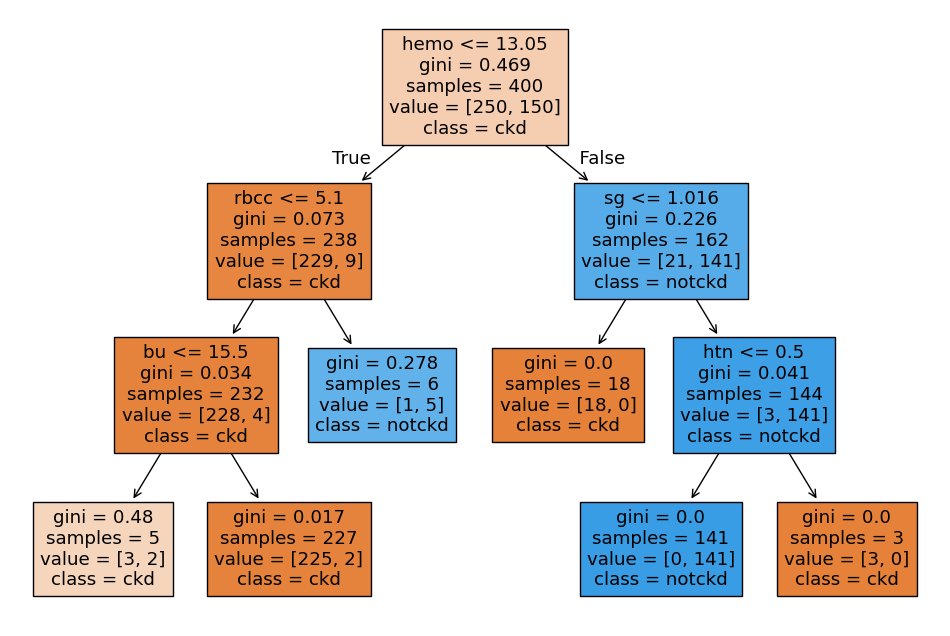

In [138]:
plt.figure(figsize=(12, 8))
plot_tree(best_model_dtc, feature_names=ALL_DATASETS[best_model_dtc_dataset_id][0].columns, class_names=["ckd","notckd"], filled=True)
plt.show()

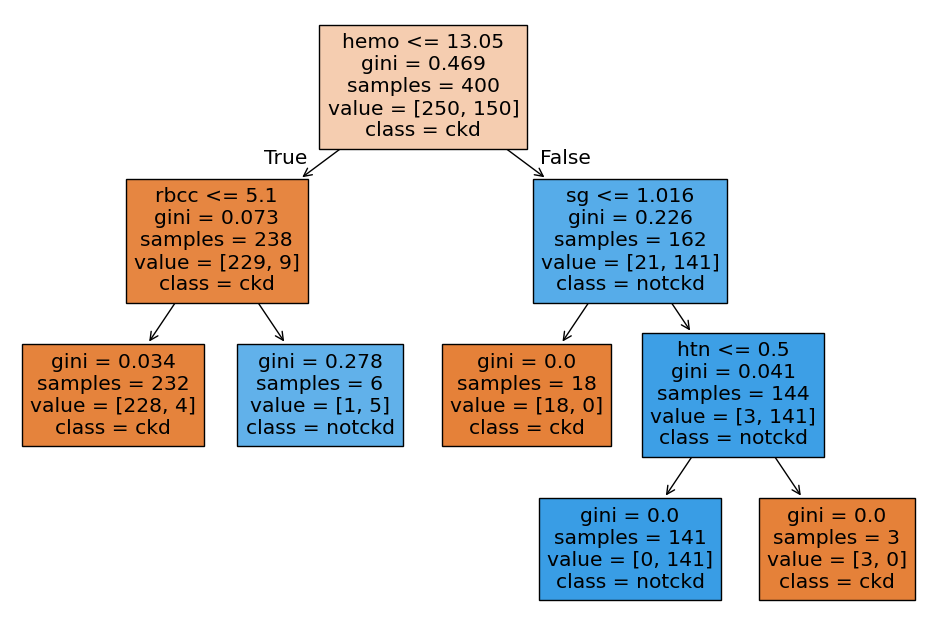

In [139]:
best_model_dtc_copy = deepcopy(best_model_dtc)
best_model_dtc_copy.tree_.children_left[2] = -1
best_model_dtc_copy.tree_.children_right[2] = -1
best_model_dtc_copy.tree_.feature[2] = -2

plt.figure(figsize=(12, 8))
plot_tree(best_model_dtc_copy, feature_names=ALL_DATASETS[best_model_dtc_dataset_id][0].columns, class_names=["ckd","notckd"], filled=True)
plt.show()

#### Ensemble learning con árboles

In [141]:
model_rfc = RandomForestClassifier()
param_grid_rfc = {
    'n_estimators': [3,5,10],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'min_impurity_decrease': [0.0, 0.1]
}

best_model_rfc, best_model_rfc_dataset_id = validacion_cruzada_con_gridsearch(model_rfc, param_grid_rfc)


Mejores hiperparámetros para el dataset 1: {'max_depth': 3, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Mejor F1-score para el dataset 1: 0.9827

Mejores hiperparámetros para el dataset 2: {'max_depth': 5, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
Mejor F1-score para el dataset 2: 0.9931

Mejores hiperparámetros para el dataset 3: {'max_depth': 3, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 3}
Mejor F1-score para el dataset 3: 0.9934

Mejores hiperparámetros para el dataset 4: {'max_depth': 3, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 5}
Mejor F1-score para el dataset 4: 0.9966


In [142]:
model_gbc = GradientBoostingClassifier()

param_grid_gbc = {
    'n_estimators': [3,5,10],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'min_impurity_decrease': [0.0, 0.1]
}

best_model_gbc, best_model_gbc_dataset_id = validacion_cruzada_con_gridsearch(model_gbc, param_grid_gbc)


Mejores hiperparámetros para el dataset 1: {'max_depth': 5, 'min_impurity_decrease': 0.1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Mejor F1-score para el dataset 1: 0.9795

Mejores hiperparámetros para el dataset 2: {'max_depth': 5, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}
Mejor F1-score para el dataset 2: 0.9695

Mejores hiperparámetros para el dataset 3: {'max_depth': 5, 'min_impurity_decrease': 0.1, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}
Mejor F1-score para el dataset 3: 0.9796

Mejores hiperparámetros para el dataset 4: {'max_depth': 3, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 3}
Mejor F1-score para el dataset 4: 0.9899


#### Modelos lineales

In [144]:
model_lr = LogisticRegression(solver="liblinear")

param_grid_lr = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'max_iter': [50,100,250,500]
}

best_model_lr, best_model_lr_dataset_id = validacion_cruzada_con_gridsearch(model_lr, param_grid_lr)


Mejores hiperparámetros para el dataset 1: {'C': 10000, 'max_iter': 50}
Mejor F1-score para el dataset 1: 0.9799

Mejores hiperparámetros para el dataset 2: {'C': 100, 'max_iter': 50}
Mejor F1-score para el dataset 2: 0.9902

Mejores hiperparámetros para el dataset 3: {'C': 1, 'max_iter': 50}
Mejor F1-score para el dataset 3: 0.9842

Mejores hiperparámetros para el dataset 4: {'C': 10, 'max_iter': 50}
Mejor F1-score para el dataset 4: 0.9934


In [145]:
model_svc = SVC(kernel='rbf')

param_grid_svc = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'gamma': [0,0.01,0.1,1],
    'max_iter': [50,100,250,500]
}

best_model_svc, best_model_svc_dataset_id = validacion_cruzada_con_gridsearch(model_svc, param_grid_svc)


Mejores hiperparámetros para el dataset 1: {'C': 0.01, 'gamma': 0.01, 'max_iter': 50}
Mejor F1-score para el dataset 1: 0.6481

Mejores hiperparámetros para el dataset 2: {'C': 10, 'gamma': 0.1, 'max_iter': 50}
Mejor F1-score para el dataset 2: 0.9935

Mejores hiperparámetros para el dataset 3: {'C': 10, 'gamma': 0.1, 'max_iter': 50}
Mejor F1-score para el dataset 3: 0.9955

Mejores hiperparámetros para el dataset 4: {'C': 10, 'gamma': 1, 'max_iter': 50}
Mejor F1-score para el dataset 4: 0.9933


#### Redes neuronales

In [147]:
model_mlp = MLPClassifier(solver='lbfgs')

param_grid_mlp = {
    'alpha': [0.001,0.1,1],
    'hidden_layer_sizes': [[10],[100],[10,10],[100,100]],
    'max_iter': [100,250,500]
}

best_model_mlp, best_model_mlp_dataset_id = validacion_cruzada_con_gridsearch(model_mlp, param_grid_mlp)


Mejores hiperparámetros para el dataset 1: {'alpha': 0.1, 'hidden_layer_sizes': [10], 'max_iter': 500}
Mejor F1-score para el dataset 1: 0.8797

Mejores hiperparámetros para el dataset 2: {'alpha': 0.001, 'hidden_layer_sizes': [10, 10], 'max_iter': 250}
Mejor F1-score para el dataset 2: 0.9933

Mejores hiperparámetros para el dataset 3: {'alpha': 0.001, 'hidden_layer_sizes': [100, 100], 'max_iter': 250}
Mejor F1-score para el dataset 3: 0.9908

Mejores hiperparámetros para el dataset 4: {'alpha': 0.001, 'hidden_layer_sizes': [10, 10], 'max_iter': 100}
Mejor F1-score para el dataset 4: 0.9934


En este último modelo, al ser de Keras, tendremos que crear la búsqueda de mejores hiperparámetros de una forma distinta. Inicialmente, intenté usar **[esta clase](https://adriangb.com/scikeras/stable/generated/scikeras.wrappers.KerasClassifier.html)**, pero no logré que me funcionase las importaciones, por lo que he tenido que reciclar el código de la práctica 4. También he tenido que limitar mucho los hiperparámetros con los que experimento y las iteraciones, ya que el entrenamiento es muy largo en este caso. También he entrenado solo los 3 primeros datasets para ahorrar más tiempo.

In [149]:
def create_model(dataset_id, hidden_layer_sizes=[10], alpha=0.001):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(hidden_layer_sizes[0], activation='relu', input_shape=(ALL_DATASETS[dataset_id][0].shape[1],)))
    for units in hidden_layer_sizes[1:]:
        model.add(keras.layers.Dense(units, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    optimizer = keras.optimizers.Adam(learning_rate=alpha)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def manual_grid_search(datasets, param_grid, epochs=20, batch_size=32):
    best_model = None
    best_score = -np.inf
    best_params = None
    best_dataset_id = None

    for dataset_id, (X, y) in enumerate(datasets):
        if dataset_id == 3:
            continue
        X = X.to_numpy().astype(float)
        y = y.to_numpy().astype(float)
        
        print(f"Evaluando dataset {dataset_id + 1}...")
        kf = KFold(n_splits=5, shuffle=True, random_state=42)

        # Iteramos sobre las combinaciones de hiperparametros
        for hidden_layer_sizes in param_grid['hidden_layer_sizes']:
            for alpha in param_grid['alpha']:
                fold_scores = []

                # Validacion cruzada
                for train_index, val_index in kf.split(X):
                    X_train, X_val = X[train_index], X[val_index]
                    y_train, y_val = y[train_index], y[val_index]

                    # Creamos y entrenamos el modelo
                    model = create_model(dataset_id, hidden_layer_sizes=hidden_layer_sizes, alpha=alpha)
                    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

                    # Evaluamos el modelo
                    y_pred = (model.predict(X_val) > 0.5).astype(int)
                    score = f1_score(y_val, y_pred)
                    fold_scores.append(score)

                # Calculamos el promedio de F1-score para este conjunto de hiperparametros
                mean_score = np.mean(fold_scores)
                print(f"Params: {hidden_layer_sizes}, alpha: {alpha}, F1-score: {mean_score:.4f}")

                # Guardamos el mejor modelo
                if mean_score > best_score:
                    best_model = model
                    best_score = mean_score
                    best_params = {'hidden_layer_sizes': hidden_layer_sizes, 'alpha': alpha}
                    best_dataset_id = dataset_id

    print("\nMejores hiperparámetros:")
    print(f"Hidden layers: {best_params['hidden_layer_sizes']}, alpha: {best_params['alpha']}")
    print(f"Mejor dataset: {best_dataset_id + 1}, Mejor F1-score: {best_score:.4f}")

    return best_model, best_dataset_id, best_params

In [150]:
param_grid = {
    'hidden_layer_sizes': [[10], [100], [32, 32]],
    'alpha': [0.001, 0.01]
}

best_model_keras, best_dataset_id_keras, best_params_keras = manual_grid_search(ALL_DATASETS, param_grid, epochs=25, batch_size=24)

Evaluando dataset 1...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002860C1C0CC0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Params: [10], alpha: 0.0

### 4.2. Evaluación del rendimiento

#### 4.2.1. Matriz de confusión

Esta es una técnia utilizada para evaluar el desempeño de un modelo de clasificación. Es una tabla que muestra cómo las predicciones del modelo se comparan con las clases reales de los datos. Cada fila de la matriz representa las etiquetas reales (valores verdaderos), mientras que cada columna representa las etiquetas predichas por el modelo (o viceversa, dependiendo de la convención). Un buen modelo tendrá valores altos en las diagonales y valores cercanos a cero (o cero) en las posiciones que no son diagonales.

In [153]:
def get_confusion_matriz(model, dataset_used):
    prediccion = model.predict(ALL_DATASETS[dataset_used][0])
    cm = confusion_matrix(ALL_DATASETS[dataset_used][1], prediccion)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

##################   KNN   ##################


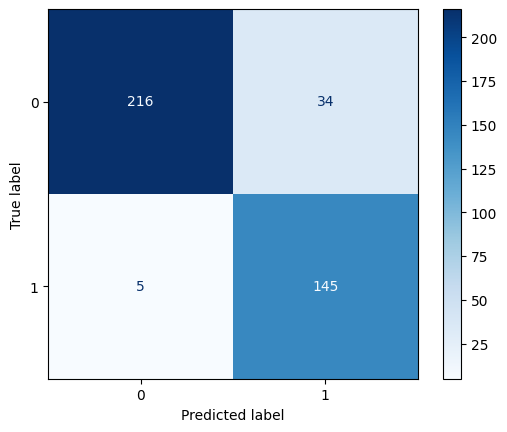

##################   Árboles de decisión   ##################


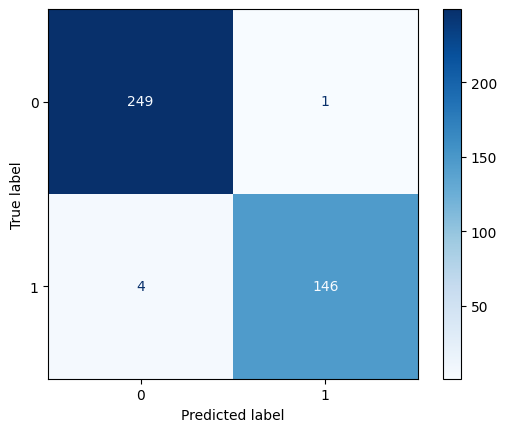

##################   Random Forest Classifier   ##################


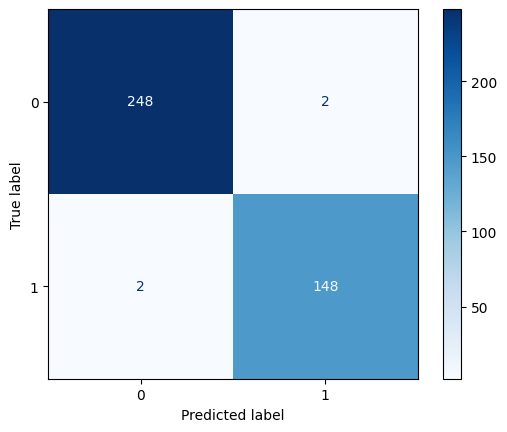

##################   Gradient Boosting Classifier   ##################


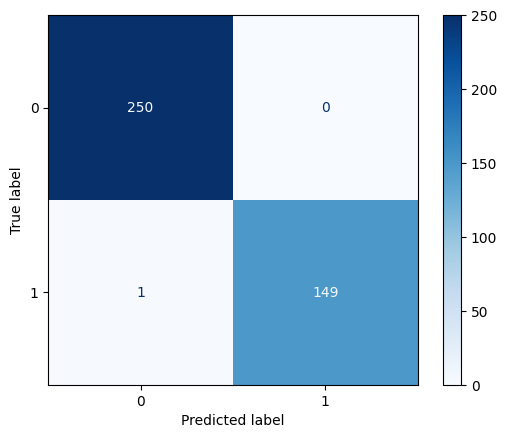

##################   Logistic Regression   ##################


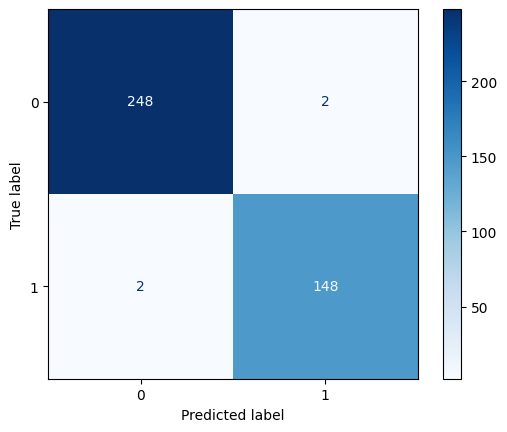

##################   SVC   ##################


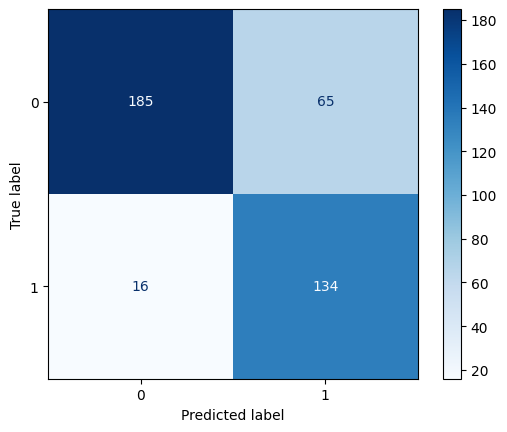

##################   MLP Classifier   ##################


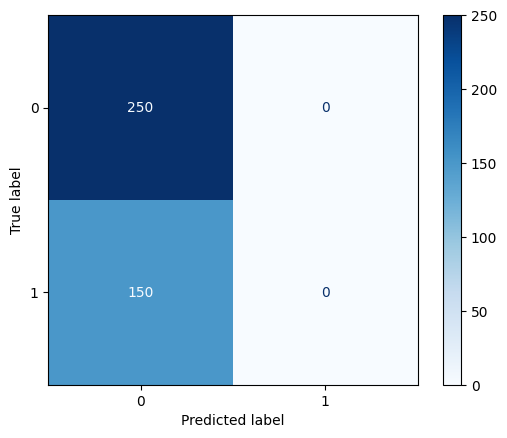

In [154]:
print("##################   KNN   ##################")
get_confusion_matriz(best_model_knn, best_model_knn_dataset_id)

print("##################   Árboles de decisión   ##################")
get_confusion_matriz(best_model_dtc, best_model_dtc_dataset_id)

print("##################   Random Forest Classifier   ##################")
get_confusion_matriz(best_model_rfc, best_model_rfc_dataset_id)

print("##################   Gradient Boosting Classifier   ##################")
get_confusion_matriz(best_model_gbc, best_model_gbc_dataset_id)

print("##################   Logistic Regression   ##################")
get_confusion_matriz(best_model_lr, best_model_lr_dataset_id)

print("##################   SVC   ##################")
get_confusion_matriz(best_model_svc, best_model_svc_dataset_id)

print("##################   MLP Classifier   ##################")
get_confusion_matriz(best_model_mlp, best_model_mlp_dataset_id)


Podemos observar que en la mayoria de los modelos hay una cantidad de falsos positivos, es decir, los modelos predice como positivos casos negativos. Esto es posible que se deba a que en el dataset 1 no se aplicó ninguna técnica para igualar la cantidad de datos positivos y negativos, por lo que un modelo que indiscriminadamente clasifique la mayoría de datos como negativos tendrá una buena puntuación.

#### 4.2.2 Informe de clasificación

Por otro lado el informe de clasificación (o classification report) es un resumen que evalúa el rendimiento de un modelo de clasificación utilizando varias métricas clave derivadas de la matriz de confusión:
- **Precisión**: Proporción de las predicciones positivas del modelo que son correctas.
- **Recall**: Proporción de los casos positivos reales que fueron detectados correctamente.
- **F1-Score**: Media armónica entre precisión y recall.
- **Support**: Número de muestras reales en cada clase.

In [156]:
def get_classification_report(model, dataset_used):
    prediccion = model.predict(ALL_DATASETS[dataset_used][0])
    report = classification_report(ALL_DATASETS[dataset_used][1], prediccion)
    print(report)

In [157]:
print("##################   KNN   ##################")
get_classification_report(best_model_knn, best_model_knn_dataset_id)

print("##################   Árboles de decisión   ##################")
get_classification_report(best_model_dtc, best_model_dtc_dataset_id)

print("##################   Random Forest Classifier   ##################")
get_classification_report(best_model_rfc, best_model_rfc_dataset_id)

print("##################   Gradient Boosting Classifier   ##################")
get_classification_report(best_model_gbc, best_model_gbc_dataset_id)

print("##################   Logistic Regression   ##################")
get_classification_report(best_model_lr, best_model_lr_dataset_id)

print("##################   SVC   ##################")
get_classification_report(best_model_svc, best_model_svc_dataset_id)

print("##################   MLP Classifier   ##################")
get_classification_report(best_model_mlp, best_model_mlp_dataset_id)

##################   KNN   ##################
              precision    recall  f1-score   support

           0       0.98      0.86      0.92       250
           1       0.81      0.97      0.88       150

    accuracy                           0.90       400
   macro avg       0.89      0.92      0.90       400
weighted avg       0.91      0.90      0.90       400

##################   Árboles de decisión   ##################
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       250
           1       0.99      0.97      0.98       150

    accuracy                           0.99       400
   macro avg       0.99      0.98      0.99       400
weighted avg       0.99      0.99      0.99       400

##################   Random Forest Classifier   ##################
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       250
           1       0.99      0.99      0.99       150

    acc

Los resultados obtenidos aquí son similares a los descritos en la matriz de confusión.

### 4.3. Curvas de rendimiento

Vamos a terminar comprobando las curvas de rendimiento. Estas son herramientas gráficas que permiten evaluar la capacidad de un modelo de clasificación, especialmente en problemas binarios. Estas curvas miden el equilibrio entre métricas como sensibilidad, precisión y especificidad a medida que varía el umbral de decisión del modelo. Como hemos aplicado validación cruzada para entrenar los modelos, usaremos el dataset entero para crear las gráficas.

#### 4.3.1. Curva PR

La curva PR (Precision-Recall) muestra la relación entre la precisión y el Recall a diferentes umbrales. Un buen modelo se acercará a la esquina superior derecha (Precisión y Recall alto). 

In [160]:
models = [
    ("KNN", best_model_knn),
    ("Decision Tree", best_model_dtc),
    ("Random Forest", best_model_rfc),
    ("Gradient Boosting", best_model_gbc),
    ("Logistic Regression", best_model_lr),
    ("SVC", best_model_svc),
    ("MLP Classifier", best_model_mlp),
]

def plot_all_precision_recall_curves(models, x, y):
    
    # Configurar las subgráficas (2 filas x 4 columnas)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Ajustar tamaño según se necesite
    axes = axes.ravel()  # Aplanar las subgráficas para fácil iteración
    
    # Iterar sobre los modelos y datasets
    for i in range(len(models)):
        model_name, model = models[i]
        # Obtener las probabilidades o los puntajes del modelo
        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(x)[:, 1]
        elif hasattr(model, "decision_function"):
            y_scores = model.decision_function(x)
        else:
            raise ValueError(f"El modelo {model_name} debe implementar predict_proba o decision_function.")
        
        # Calcular precisión, recall y AUC-PR
        precision, recall, _ = precision_recall_curve(y, y_scores)
        auc_pr = average_precision_score(y, y_scores)
        
        # Dibujar la curva en la subgráfica correspondiente
        axes[i].plot(recall, precision, label=f"AUC = {auc_pr:.2f}", color="blue")
        axes[i].set_title(f"{model_name}")
        axes[i].set_xlabel("Recall")
        axes[i].set_ylabel("Precision")
        axes[i].legend()
        axes[i].grid()

    # Ajustar el diseño
    plt.tight_layout()
    plt.show()

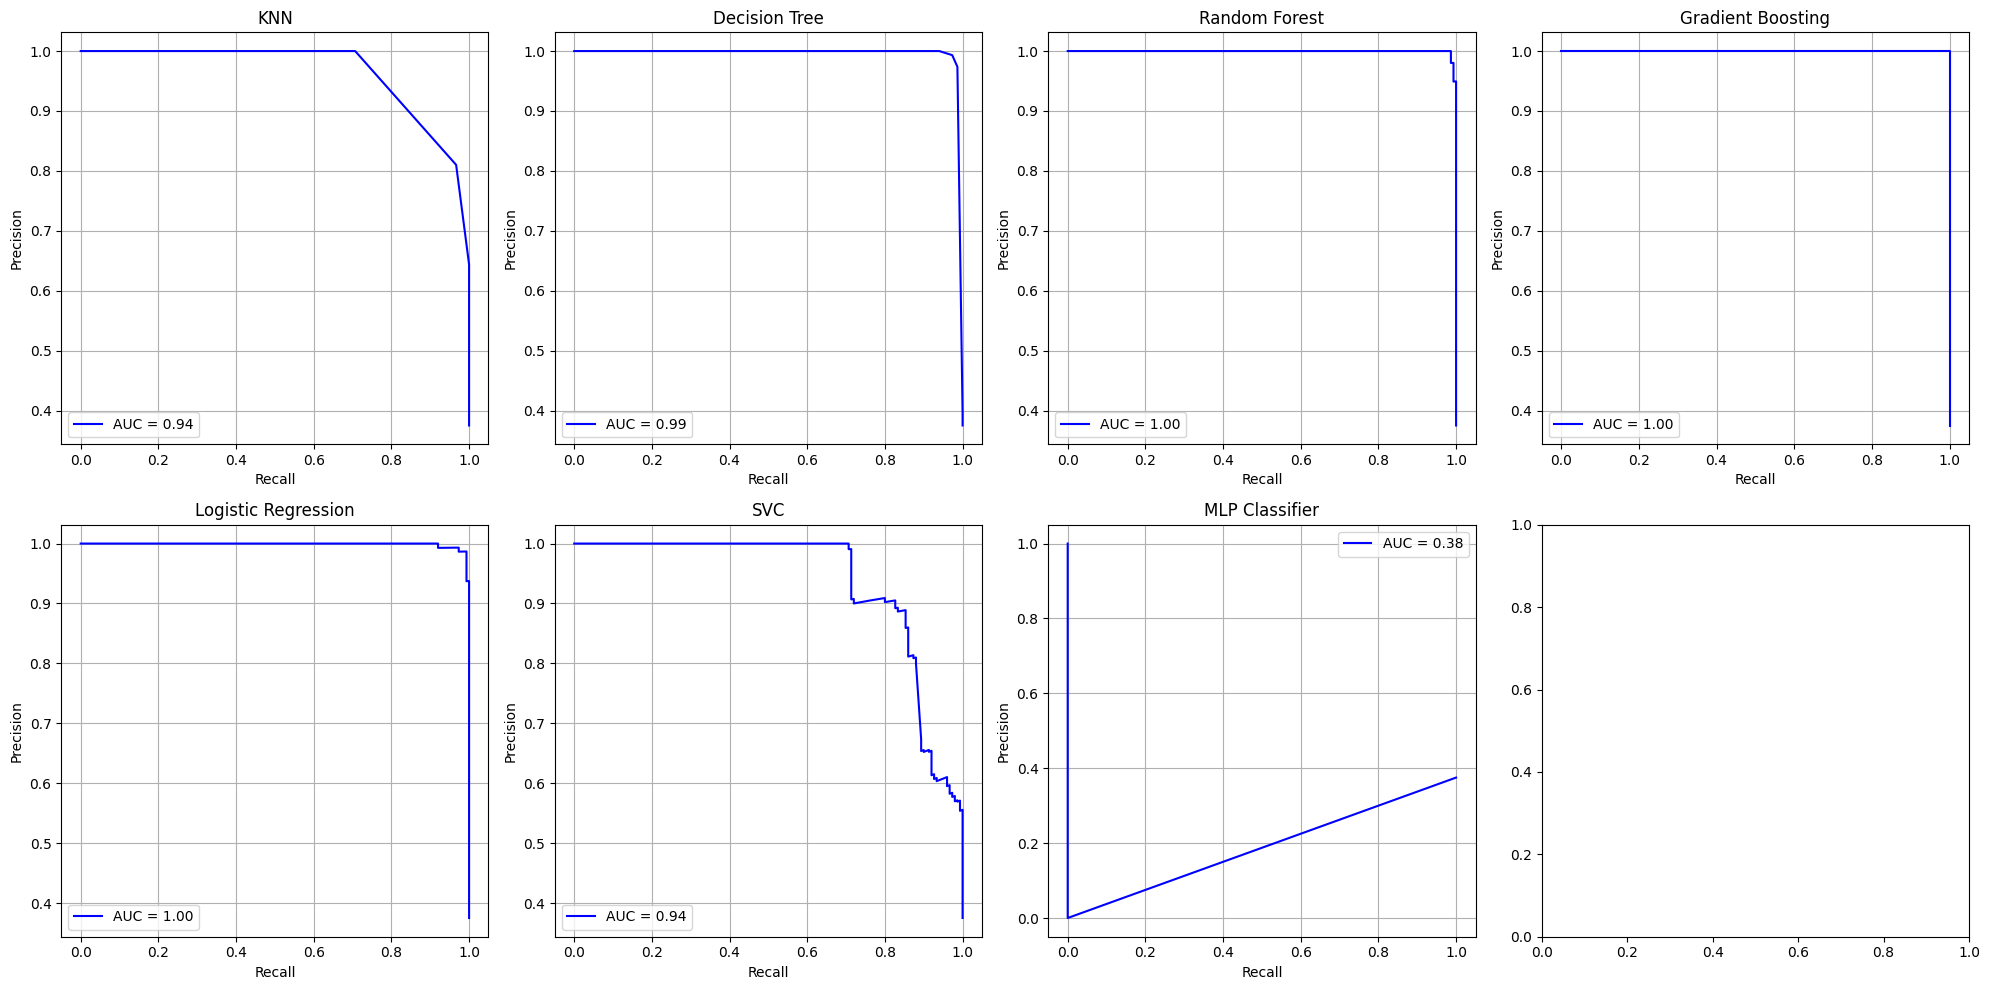

In [161]:
plot_all_precision_recall_curves(models, ALL_DATASETS[0][0], ALL_DATASETS[0][1])

Como podemos observar, modelos como Gradient Boosting y Random Forest parecen dar muy buenos resultados, mientras que otros como KNN, SVC y MLP Classifier dan curvas alejadas de la esquina superior derecha.

#### 4.3.2 Curva ROC

La curva ROC (Receiver Operating Characteristic) muestra la relación entre la Tasa de Verdaderos Positivos (TPR) o Sensibilidad y la Tasa de Falsos Positivos (FPR) a diferentes umbrales. Un modelo perfecto tendrá una curva que pasa por la esquina superior izquierda (100% TPR y 0% FPR), mientras que un modelo aleatorio sigue la diagonal.

In [163]:
def plot_all_roc_curves(models, x, y):
    # Configurar las subgráficas (2 filas x 4 columnas)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Ajustar tamaño según se necesite
    axes = axes.ravel()  # Aplanar las subgráficas para fácil iteración
    
    # Iterar sobre los modelos y datasets
    for i in range(len(models)):
        model_name, model = models[i]
        # Obtener las probabilidades o los puntajes del modelo
        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(x)[:, 1]
        elif hasattr(model, "decision_function"):
            y_scores = model.decision_function(x)
        else:
            raise ValueError(f"El modelo {model_name} debe implementar predict_proba o decision_function.")
        
        # Calcular la curva ROC y AUC-ROC
        fpr, tpr, _ = roc_curve(y, y_scores)
        auc_roc = auc(fpr, tpr)
        
        # Dibujar la curva ROC en la subgráfica correspondiente
        axes[i].plot(fpr, tpr, label=f"AUC = {auc_roc:.2f}", color="blue")
        axes[i].set_title(f"{model_name}")
        axes[i].set_xlabel("False Positive Rate")
        axes[i].set_ylabel("True Positive Rate")
        axes[i].plot([0, 1], [0, 1], linestyle="--", color="gray")  # Línea diagonal (AUC = 0.5)
        axes[i].legend()
        axes[i].grid()

    # Ajustar el diseño
    plt.tight_layout()
    plt.show()

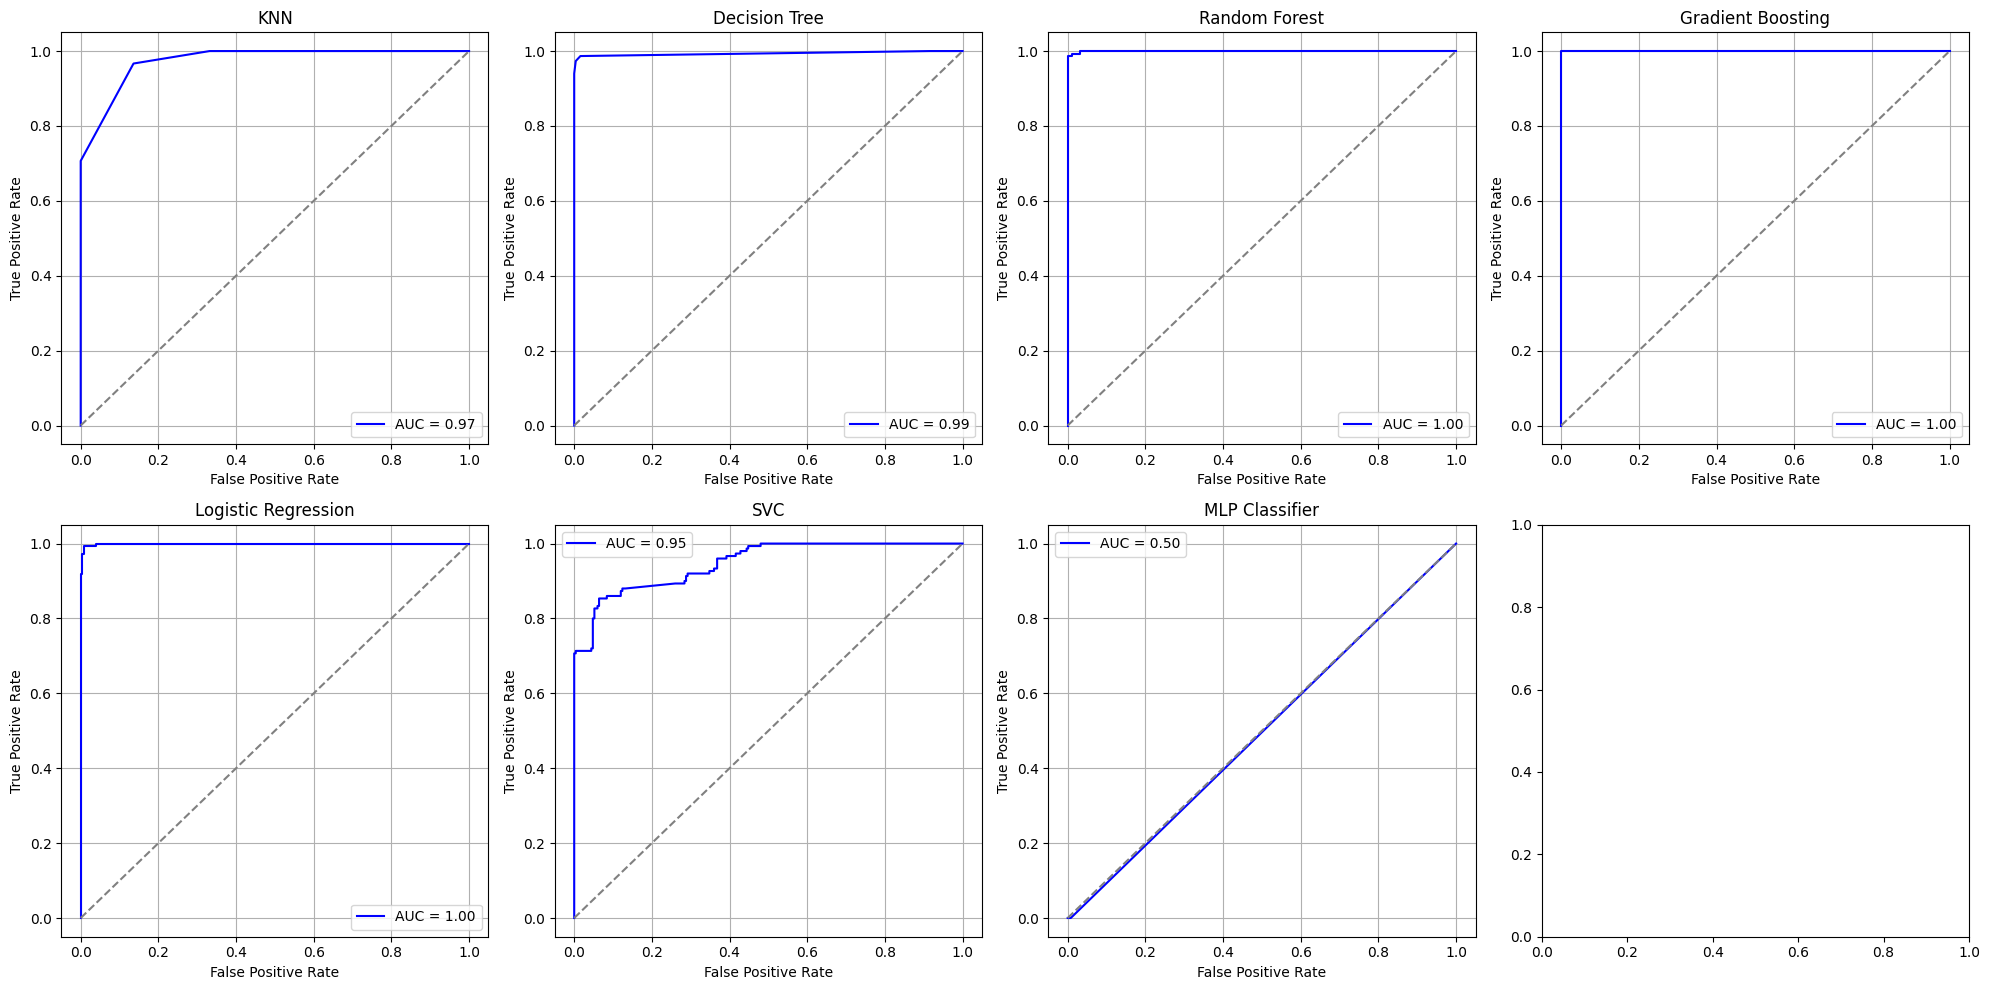

In [164]:
plot_all_roc_curves(models, ALL_DATASETS[0][0], ALL_DATASETS[0][1])

Los resultados son similares que en la curva anterior. Los buenos modelos se acercan a la esquina superior izquierda, mientra que los malos a la diagonal.

# 5. Conclusiones

Esta tarea me ha gustado, la asignatura en general me gusta mucho, y tener una "prueba final" donde hay que poner en práctica todo lo aprendido me ha gustado. Sin embargo, esta tarea es, de momento, el trabajo más grande que he tenido que hacer en el máster, y solo dan 12 días para hacerla. Como no tengo mucho que decir hacerca del trabajo aparte de que Keras solo me ha dado problemas, escribiré mi feedback de la asignatura.

La única queja que tengo del trabajo, y de la asignatura en general, es que, a pesar de que desde el día 1 todo el contenido ya está publicado en la Enseñanza Virtual, para acceder a cierto contenido debes esperar ciertas semanas. Me hubiese gustado que la liberación de 1 tema por semana no hubiese existido, para poder adelantar tareas cuando fuese posible, sobre todo cuando en la tarea de la semana 5 piden aplicar técnicas que no se enseñan hasta la semana 6 y 7. He tenido la suerte de ya conocer esas técnicas porque el TFM lo estoy haciendo de Machine Learning, pero, al menos desde mi punto de vista, me parece algo innecesario, y de momento esta asignatura es la única del máster que lo hace.